Adam Miles
CS6017
Homework3
## Part 1: Data Acquisition

Web scraper script runs external to this notebook, collects first 5 pages of links on Hacker News. The following fields are collected for each link:
    'comments' (int): the number of comments for the post.
    'rank' (int): the rank of the post.
    'score' (int): the score of the post.
    'age' (float): the age of the article in hours.
    'title_length': the length of the title in characters.

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns; sns.set(style="ticks", color_codes=True)
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings("ignore")



In [2]:
filepath='/Users/adam/Box Sync/milesar/CS 6017/Homework3' 
os.chdir(filepath)
%run HNScraperTest.py

Analyzing page #1...
Analyzing page #2...
Analyzing page #3...
Analyzing page #4...
Analyzing page #5...


Load the latest scrape results into a dataframe.

In [3]:
files = os.listdir(filepath)
results = [ fi for fi in files if fi.endswith(".csv") ]
df = pd.read_csv(results[0])
assert len(df) == 150

Most of the cleaning is handled during scraping ('discuss' = 0 comments, minutes/days => hours conversion, etc), but some of the parsing routines will add a NaN string to the table for easy cleaning here. Types are adjusted as appropriate.

In [4]:
df_clean = df.dropna()
cols = ['comments', 'rank']
df_clean[cols] = df_clean[cols].applymap(np.int64)
# drop outliers in score
df_clean = df_clean[df_clean['score'] < 500]

## Part 2: Regression

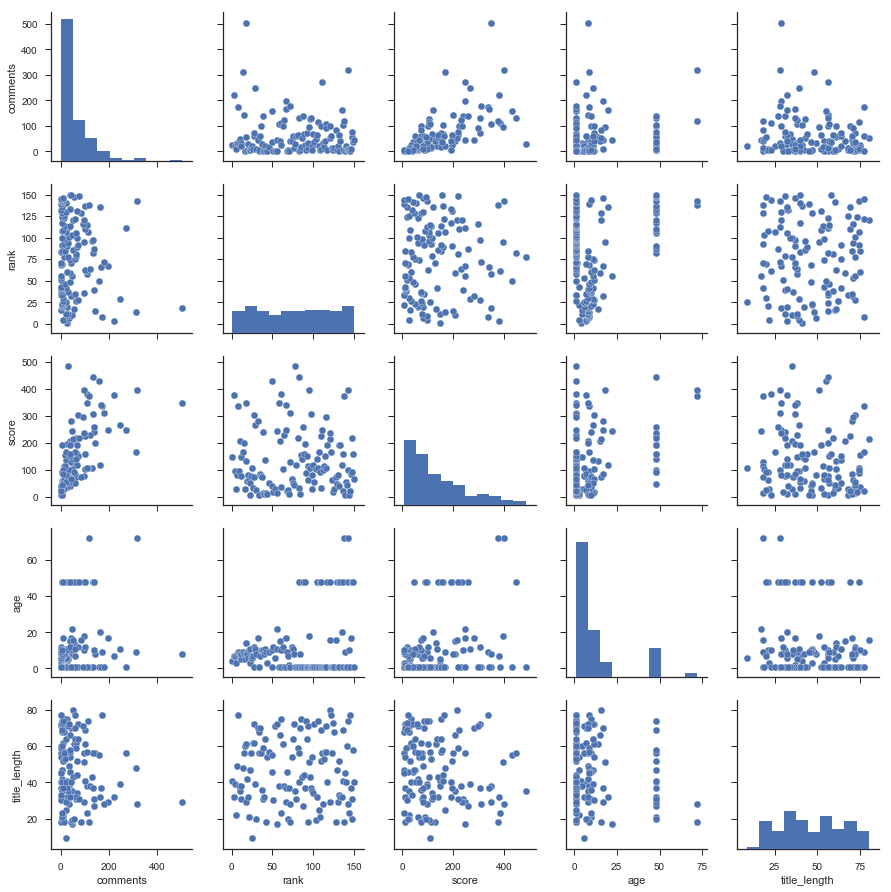

In [5]:
g = sns.pairplot(df_clean)

### Initial observations of the vs plots

Since we are looking for any trends that might correlate with the ranking, it probably makes sense to start with the rank column (or row) of the vs plots. It seems like we are ignoring a pretty significant component of the post, which is the content itself.

Abstracting away the content and any trenindg keywords, there are no clearly linear trends from observation alone . Title length especially seems to have a fairly normal, random distribution with respect to title indicating that beyond having a title there is no clear relationship to what we might predict the rank to be.

Observation does reveal some intutitive correlations between other features that might prove noteworthy. 

##### Age
Because the age of each posting loses precision after 24 hrs, it is difficult to monitor trends with uniform granularity across the data set. We can see that most of the distribution in rank lies with articles less than 24 hrs old, and that articles over 2 days old are few but highly ranked. Age only helps us in that if an article is old and is listed on the top 5 pages of HackerNews, it is more likely to be highly rated (to have survived that long presumably).

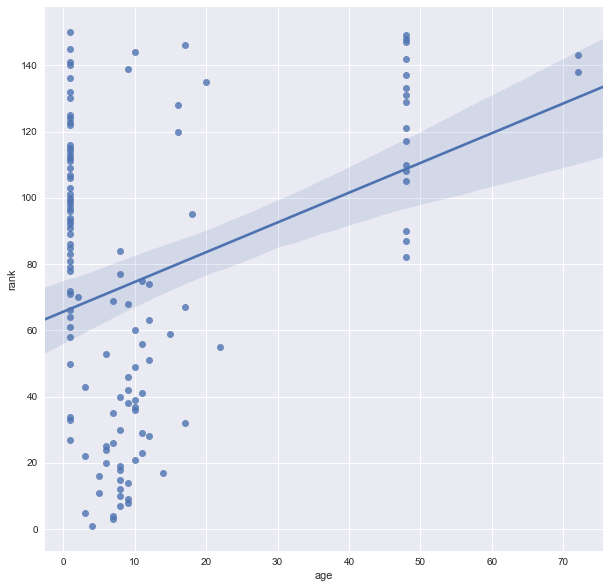

In [6]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["age"], y=df_clean["rank"])

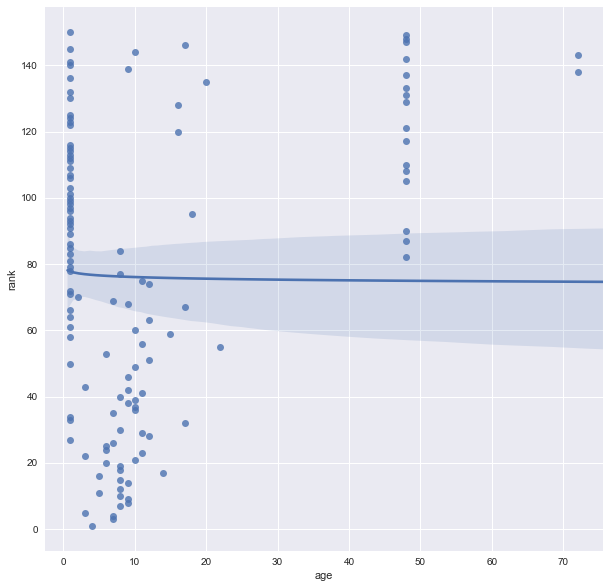

In [7]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["age"], y=df_clean["rank"], fit_reg=True, logx=True)

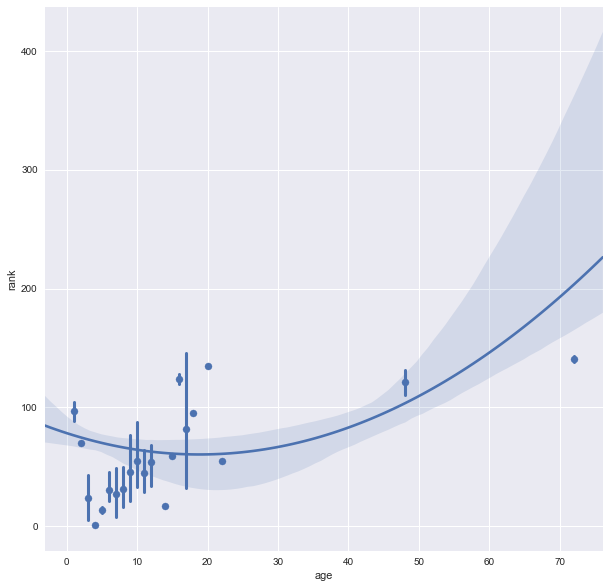

In [8]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["age"], y=df_clean["rank"], fit_reg=True, order=2, x_estimator=np.mean)

##### Comments and Score
The number of comments and the score do not directly correlate with the rank of an article. They do however correlate rather strongly with each other. The pearsonr value is 0.74, indicating a healthy positive trend, and the p value is quite small. This could makes sense from the perspective of engagement: the more people are inclined to comment on an article, the more they have engaged with it and have been inclined to upvote. In researching how HN works, however, it seems that upvotes and flags do not always get counted: there seems to be something else going on behing the scenes to determine the ultimate score. In any case, since these features do correlate fairly closely, we might have to be careful when using them.

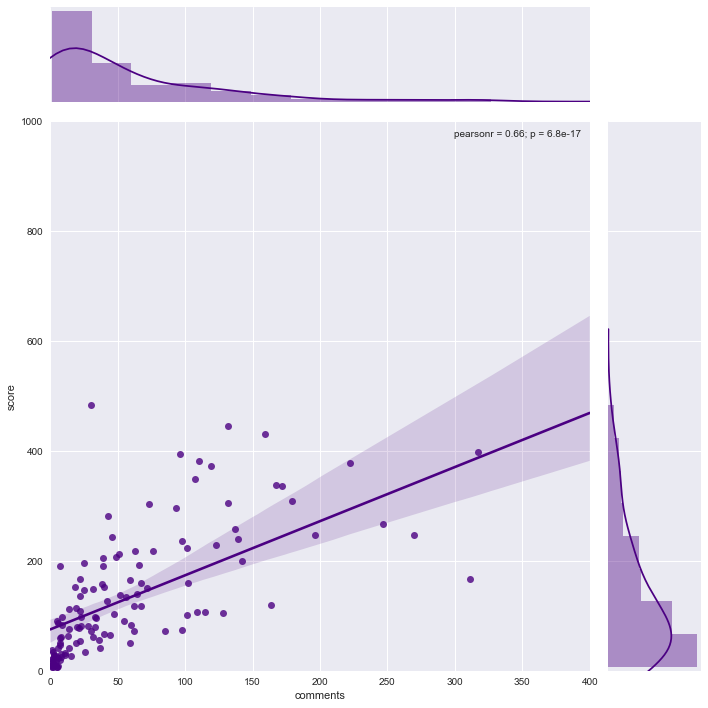

In [9]:
g = sns.jointplot("comments", "score", data=df_clean, kind="reg", xlim=(0, 400), ylim=(0, 1000), color="indigo", size=10)

#### Score alone
Excluding the outliers (score > 500), there is no particularly strong correlation between score and rank alone.

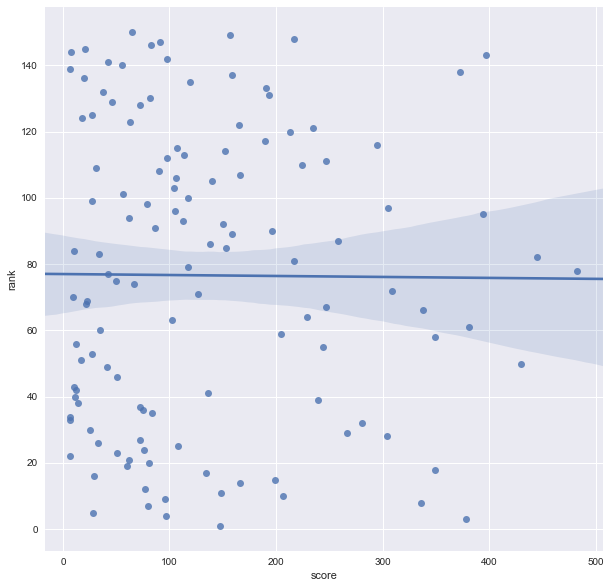

In [10]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["score"], y=df_clean["rank"])

#### Title length
I mention title length only because it stands out as having very little to do with the rank of the post. It does not seem like it will prove useful in determing the rank of an article. The distribution of rankings is almost uniform, and it is no surprise that the pearsonr value is very low (0.033) and the p value is quite high (0.71).

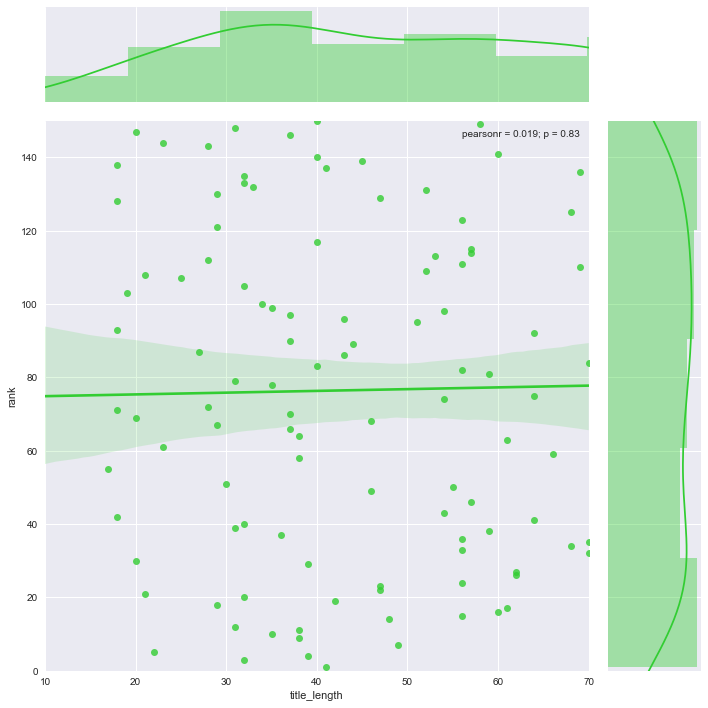

In [11]:
g = sns.jointplot("title_length", "rank", data=df_clean, kind="reg", xlim=(10, 70), ylim=(0, 150), color="limegreen", size=10)

### Building models

Based on the intial observations above, it seems prudent to focus our models on combinations of 3 variables: score, age, and comments.

A good place to start seems to be the article score.

### Score alone

In [12]:
model1 = ols("rank ~ score", data=df_clean).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.006937
Date:                Thu, 07 Jun 2018   Prob (F-statistic):              0.934
Time:                        11:05:01   Log-Likelihood:                -656.07
No. Observations:                 126   AIC:                             1316.
Df Residuals:                     124   BIC:                             1322.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.9937      6.142     12.536      0.000      64.838      89.150
score         -0.0029      0.035     -0.083      0.934      -0.072       0.066
==============================================================================
Omnibus:                       61.514   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.233
Skew:                          -0.027   Prob(JB):                       0.0163
Kurtosis:                       1.749   Cond. No.                         273.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value is really quite bad relying on score alone (p = 0.934), and the confidence intervals are equally attrocious. So this model wont help us much in predicting the rank, as we might have guessed above.

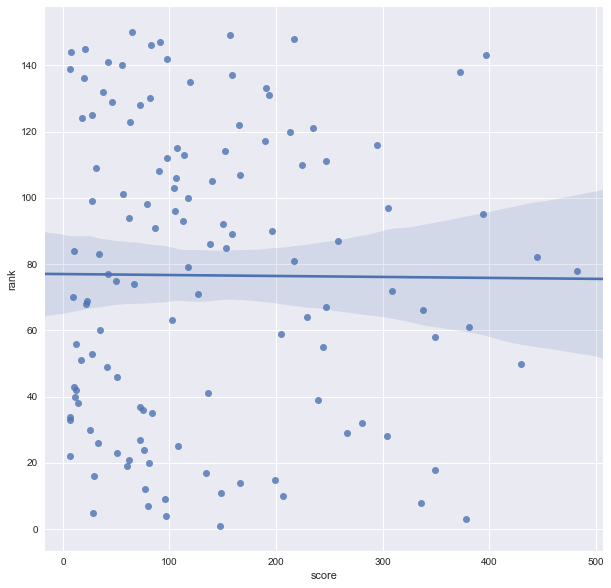

In [13]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["score"], y=df_clean["rank"])

### Score and comments

In [14]:
model2 = ols("rank ~ score + comments", data=df_clean).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.5211
Date:                Thu, 07 Jun 2018   Prob (F-statistic):              0.595
Time:                        11:05:02   Log-Likelihood:                -655.54
No. Observations:                 126   AIC:                             1317.
Df Residuals:                     123   BIC:                             1326.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     77.0780      6.141     12.551      0.000      64.921      89.235
score          0.0280      0.046      0.605      0.546      -0.064       0.120
comments      -0.0704      0.069     -1.017      0.311      -0.207       0.067
==============================================================================
Omnibus:                       52.168   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.807
Skew:                          -0.007   Prob(JB):                       0.0202
Kurtosis:                       1.781   Cond. No.                         301.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here our p-values have improved somewhat, but they are still quite high and the model will not prove very useful for our purposes.



### Comments and age

In [15]:
model3 = ols("rank ~ comments + age", data=df_clean).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     9.325
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           0.000170
Time:                        11:05:02   Log-Likelihood:                -647.18
No. Observations:                 126   AIC:                             1300.
Df Residuals:                     123   BIC:                             1309.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.5209      5.258     13.223      0.000      59.114      79.928
comments      -0.0758      0.049     -1.532      0.128      -0.174       0.022
age            0.9521      0.225      4.228      0.000       0.506       1.398
==============================================================================
Omnibus:                       37.635   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.982
Skew:                           0.020   Prob(JB):                       0.0305
Kurtosis:                       1.847   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-values for comments is much improved, with age proving to be a good indicator of the rank (for its share).

### Age, comments, and score

In [16]:
model4 = ols("rank ~ age + comments + score", data=df_clean).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     6.238
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           0.000563
Time:                        11:05:02   Log-Likelihood:                -647.08
No. Observations:                 126   AIC:                             1302.
Df Residuals:                     122   BIC:                             1314.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.7213      5.963     11.861      0.000      58.918      82.525
age            0.9775      0.233      4.187      0.000       0.515       1.440
comments      -0.0576      0.065     -0.885      0.378      -0.186       0.071
score         -0.0194      0.045     -0.432      0.667      -0.108       0.069
==============================================================================
Omnibus:                       42.975   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.314
Skew:                           0.003   Prob(JB):                       0.0258
Kurtosis:                       1.820   Cond. No.                         312.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Age, title_length, comments, score

Just for completion, here is a linear model that takes into account all 4 parameters that we have access to.

In [17]:
model4 = ols("rank ~ age + comments + score + title_length", data=df_clean).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     4.838
Date:                Thu, 07 Jun 2018   Prob (F-statistic):            0.00118
Time:                        11:05:02   Log-Likelihood:                -646.73
No. Observations:                 126   AIC:                             1303.
Df Residuals:                     121   BIC:                             1318.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       61.8985     12.213      5.068      0.000      37.721      86.076
age              1.0083      0.237      4.260      0.000       0.540       1.477
comments        -0.0541      0.065     -0.829      0.409      -0.183       0.075
score           -0.0187      0.045     -0.417      0.677      -0.108       0.070
title_length     0.1758      0.212      0.828      0.409      -0.244       0.596
==============================================================================
Omnibus:                       45.154   Durbin-Watson:                   0.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.443
Skew:                           0.012   Prob(JB):                       0.0242
Kurtosis:                       1.810   Cond. No.                         647.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Final OLS observations

The best OLS model turned out to rely on the number of comments and age (model 3) associated with an article. Overall though, it does not seem that an OLS derived model is the best way to approach looking at this data.

## Part 3: Classification

Step one of the logistic regression: convert the rank data to reflect the presence of an article on the front page (1 if in the top 30, 0 if anywhere else in our data set.

Since age and the number of comments were the most helpful in the OLS regression above, those were the first two attempted here.

In [18]:
df_clean['frontpage'] = np.where(df_clean['rank'] > 30, 0, 1)

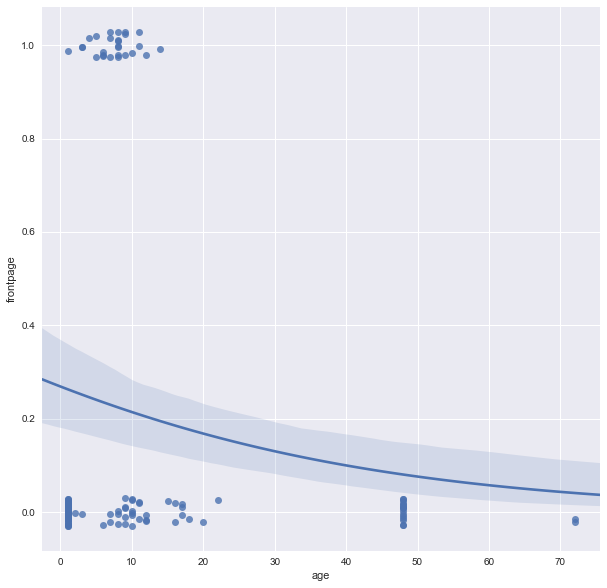

In [19]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["age"], y=df_clean["frontpage"], logistic=True, n_boot=500, y_jitter=.03)

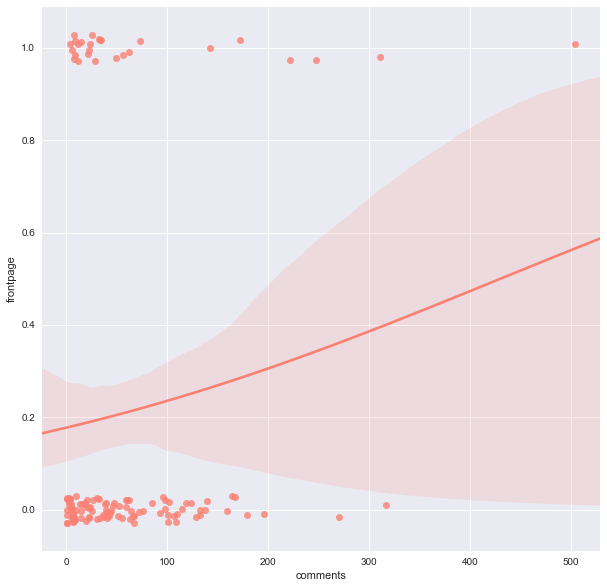

In [20]:
sns.set(style="darkgrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=df_clean["comments"], y=df_clean["frontpage"], logistic=True, n_boot=500, y_jitter=.03, color="salmon")

I really struggled to uncover any useful models or key features that would help predict the rank (or write an article that would be more likely to be highly ranked). I suspect content has a lot to do with ranking, and that I should have attempted some more complex modeling between the features chosen.